# QAPLIB Figures

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from pkg.gmp import quadratic_assignment
from pkg.gmp import quadratic_assignment_ot
from pkg.plot import set_theme
import numpy as np

In [3]:
# hide
import sys
sys.path
sys.path.insert(0,'../../graspologic')

# Recreate fig 4 from FAQ Paper
## Caption:
Relative accuracy between FAQ and GOAT, defined as y=log($OFV_{GOAT} \over {OFV_{FAQ}}$). Performance is compared using the minimum objective function value over 100 random initializations, and the objective function value of a barycenter initialization with one random shuffle. Initializations and shuffles are the same across FAQ and GOAT.


In [376]:
from os import listdir
from os.path import isfile, join
import time

qapprob = ["bur26a", "bur26b", "bur26c", "bur26d", "bur26e", "bur26f",
              "bur26g", "bur26h", "chr12a", "chr12b", "chr12c", "chr15a",
              "chr15b", "chr15c", "chr18a", "chr18b", "chr20a", "chr20b",
              "chr20c", "chr22a", "chr22b", "chr25a",
              "els19",
              "esc16a", "esc16b", "esc16c", "esc16d", "esc16e", "esc16g",
              "esc16h", "esc16i", "esc16j", "esc32e", "esc32g", "esc128",
              "had12", "had14", "had16", "had18", "had20", "kra30a",
              "kra30b", "kra32",
              "lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
              "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
              "lipa80a", "lipa90a", "lipa90b",
              "nug12", "nug14", "nug16a", "nug16b", "nug17", "nug18", "nug20",
              "nug21", "nug22", "nug24", "nug25", "nug27", "nug28", "nug30",
              "rou12", "rou15", "rou20",
              "scr12", "scr15", "scr20",
              "sko42", "sko49", "sko56", "sko64", "sko72", "sko81", "sko90",
              "sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",
              "ste36b", "ste36c",
              "tai12a", "tai12b", "tai15a", "tai15b", "tai17a", "tai20a",
              "tai20b", "tai25a", "tai25b", "tai30a", "tai30b", "tai35a",
              "tai40a", "tai40b", "tai50a", "tai50b", "tai60a", "tai60b",
              "tai64c", "tai80a", "tai100a", "tai100b", "tai150b", "tai256c",
              "tho30", "tho40", "tho150", "wil50", "wil100"]

n_qap = len(qapprob)
slnfile = np.load("../data/qaplib/qap_sols.npz",allow_pickle=True)
datafile = np.load("../data/qaplib/qap_probs.npz",allow_pickle=True)

sizes = np.zeros(n_qap)
logofv = np.zeros(n_qap)
n_init = 100
scores_faq_r = np.zeros((n_qap,n_init))
scores_goat_r = np.zeros((n_qap,n_init))
times_faq_r = np.zeros(n_qap)
times_goat_r = np.zeros(n_qap)
for i in range(n_qap):
    A = datafile[qapprob[i]][0]
    B = datafile[qapprob[i]][1]
    n = A.shape[0]
    sizes[i] = n
    rng = check_random_state(i)
    
    options = {'tol':1e-6,'maxiter': 50,'P0': 'randomized', 'shuffle_input':True}
    start = time.time()
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))
    times_faq_r[i] = (time.time()-start)/n_init
    res = min(results, key=lambda x: x.fun,)
    scores_faq_r[i,:] = [x.fun for x in results]
    gm_score = res.fun
    
    options = {'tol':1e-6,'maxiter': 50,'P0': 'randomized', 'shuffle_input':True, 'reg': 500, 'thr':1e-2}
    start = time.time()
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment_ot)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))
    times_goat_r[i] = (time.time()-start)/n_init
    res = min(results, key=lambda x: x.fun,)
    scores_goat_r[i,:] = [x.fun for x in results]
      
    logofv[i] = np.log10(res.fun/gm_score)
    


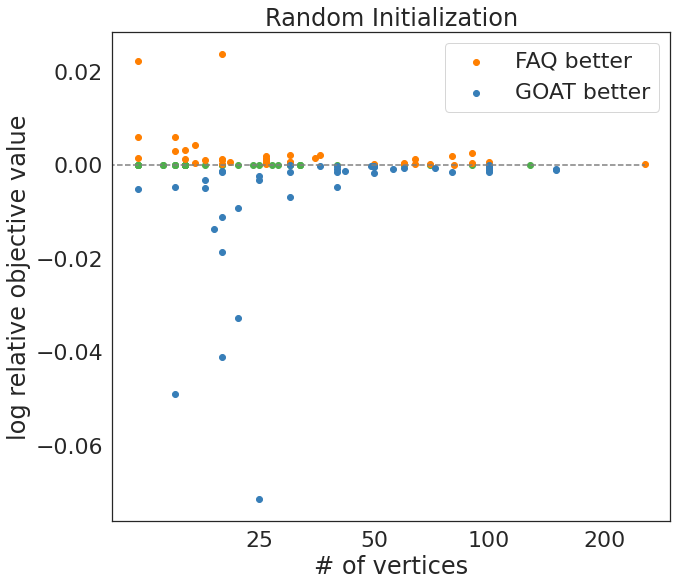

In [381]:
import matplotlib.pyplot as plt
import seaborn as sns

cb = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(10,9)})
sns.set(font_scale = 2)
sns.set_style('white')
ax.hlines(0,0,np.max(sizes),linestyles='dashed', color = 'grey')
ax.scatter(sizes[logofv==0],logofv[logofv==0], color=cb[2])
ax.scatter(sizes[logofv>0],logofv[logofv>0], color = cb[1],label='FAQ better')
ax.scatter(sizes[logofv<0],logofv[logofv<0], color=cb[0],label='GOAT better')
# ax.scatter(np.mean(sizes), np.mean(logofv), color = cb[3])
ax.legend()
ax.set_xlabel('# of vertices')
ax.set_ylabel('log relative objective value')
ax.set_xscale('log')
ax.set_title('Random Initialization')
form = ScalarFormatter()
form.set_scientific(False)
ax.xaxis.set_major_formatter(form)
ax.set_xticks([25,50,100,200])

In [368]:
from scipy.stats import ranksums, mannwhitneyu, wilcoxon
print(f'p-value: {mannwhitneyu(np.min(scores_faq_r, axis=1), np.min(scores_goat_r, axis=1)).pvalue}')

p-value: 0.49963814754139707


In [378]:
n_qap = len(qapprob)

print(f'percent GOAT better = {np.sum(logofv < 0)/n_qap}')
print(f'percent FAQ better = {np.sum(logofv > 0)/n_qap}')
print(f'percent same = {np.sum(logofv == 0)/n_qap}')

percent GOAT better = 0.3442622950819672
percent FAQ better = 0.3360655737704918
percent same = 0.319672131147541


In [385]:
from os import listdir
from os.path import isfile, join

qapprob = ["bur26a", "bur26b", "bur26c", "bur26d", "bur26e", "bur26f",
              "bur26g", "bur26h", "chr12a", "chr12b", "chr12c", "chr15a",
              "chr15b", "chr15c", "chr18a", "chr18b", "chr20a", "chr20b",
              "chr20c", "chr22a", "chr22b", "chr25a",
              "els19",
              "esc16a", "esc16b", "esc16c", "esc16d", "esc16e", "esc16g",
              "esc16h", "esc16i", "esc16j", "esc32e", "esc32g", "esc128",
              "had12", "had14", "had16", "had18", "had20", "kra30a",
              "kra30b", "kra32",
              "lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
              "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
              "lipa80a", "lipa90a", "lipa90b",
              "nug12", "nug14", "nug16a", "nug16b", "nug17", "nug18", "nug20",
              "nug21", "nug22", "nug24", "nug25", "nug27", "nug28", "nug30",
              "rou12", "rou15", "rou20",
              "scr12", "scr15", "scr20",
              "sko42", "sko49", "sko56", "sko64", "sko72", "sko81", "sko90",
              "sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",
              "ste36b", "ste36c",
              "tai12a", "tai12b", "tai15a", "tai15b", "tai17a", "tai20a",
              "tai20b", "tai25a", "tai25b", "tai30a", "tai30b", "tai35a",
              "tai40a", "tai40b", "tai50a", "tai50b", "tai60a", "tai60b",
              "tai64c", "tai80a", "tai100a", "tai100b", "tai150b", "tai256c",
              "tho30", "tho40", "tho150", "wil50", "wil100"]

n_qap = len(qapprob)

sizes = np.zeros(n_qap)
logofv = np.zeros(n_qap)
n_init = 1
scores_faq = np.zeros((n_qap,n_init))
scores_goat = np.zeros((n_qap,n_init))
for i in range(n_qap):
    A = datafile[qapprob[i]][0]
    B = datafile[qapprob[i]][1]
    n = A.shape[0]
    sizes[i] = n
    rng = check_random_state(None)
    
    options = {'tol':1e-6,'maxiter': 50, 'shuffle_input':True}
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))
#     scores_faq[i,:] = [x.fun for x in results]
    scores_faq[i,:] = [x.fun for x in results]
    gm_score = np.median(scores_faq[i,:])
    
    options = {'tol':1e-6,'maxiter': 100, 'shuffle_input':True, 'reg': 700, 'thr':1e-2}
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment_ot)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))
#     scores_goat[i,:] = [x.fun for x in results]
    scores_goat[i,:] = [x.fun for x in results]
    logofv[i] = np.log10(np.median(scores_goat[i,:])/gm_score)
    


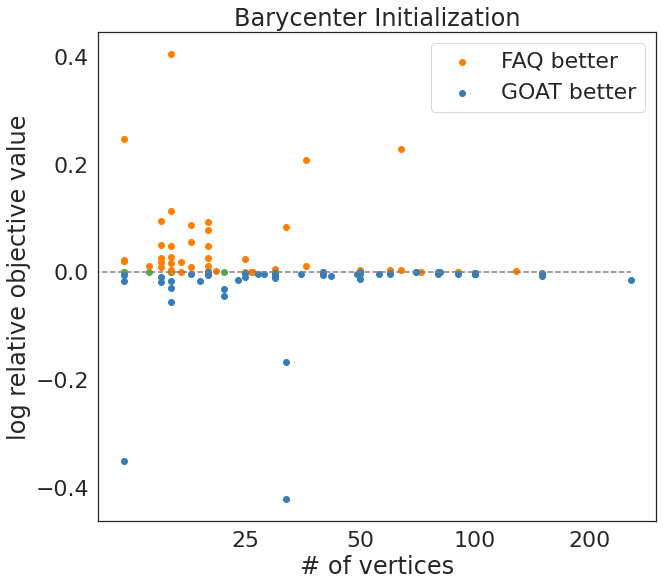

In [391]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(10,9)})
sns.set(font_scale = 2)
sns.set_style('white')
ax.hlines(0,0,np.max(sizes),linestyles='dashed', color = 'grey')
ax.scatter(sizes[logofv==0],logofv[logofv==0], color=cb[2])
ax.scatter(sizes[logofv>0],logofv[logofv>0], color = cb[1],label='FAQ better')
ax.scatter(sizes[logofv<0],logofv[logofv<0], color=cb[0],label='GOAT better')
ax.set_title('Barycenter Initialization')
# ax.scatter(np.mean(sizes), np.mean(logofv), color = cb[3])
ax.legend()
ax.set_xlabel('# of vertices')
ax.set_ylabel('log relative objective value')
ax.set_xscale('log')
form = ScalarFormatter()
form.set_scientific(False)
ax.xaxis.set_major_formatter(form)
ax.set_xticks([25,50,100,200])

In [389]:
from scipy.stats import ranksums, mannwhitneyu
print(f'p-value: {mannwhitneyu(np.median(scores_faq, axis=1), np.median(scores_goat, axis=1)).pvalue}')


p-value: 0.4916780371936752


In [388]:
print(f'percent GOAT better = {np.sum(logofv < 0)/n_qap}')
print(f'percent FAQ better = {np.sum(logofv > 0)/n_qap}')
print(f'percent same = {np.sum(logofv == 0)/n_qap}')

percent GOAT better = 0.47540983606557374
percent FAQ better = 0.4180327868852459
percent same = 0.10655737704918032


# QAPLIB Benchmark with barycenter init, 50 random shuffles

In [343]:
from joblib import Parallel, delayed
from sklearn.utils import check_random_state
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
# qapprob = ["lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
#               "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
#               "lipa80a", "lipa90a", "lipa90b"]
# qapprob =["sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",]
n_qap = len(qapprob)
slnfile = np.load("../data/qaplib/qap_sols.npz",allow_pickle=True)
datafile = np.load("../data/qaplib/qap_probs.npz",allow_pickle=True)
n_qap = len(qapprob)

gm_scores = np.zeros(n_qap)
gmot_scores = np.zeros(n_qap)
rng = check_random_state(0)
for i in range(n_qap):

    A = datafile[qapprob[i]][0]
    B = datafile[qapprob[i]][1]
    n = A.shape[0]

    n_init=1
    options={'tol':1e-6,'maxiter':100, 'shuffle_input':True}
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))
    res = min(results, key=lambda x: x.fun,)
    gm_scores[i] = res.fun
    
    options={'tol':1e-6,'maxiter':100,'shuffle_input':True, 'reg': 50, 'thr':1e-2}
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment_ot)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))  
    res = min(results, key=lambda x: x.fun,)
    gmot_scores[i] = res.fun

In [344]:
import pandas as pd
opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,3))
mat[:,0] = opt
mat[:,1] = gm_scores
mat[:,2] = gmot_scores
mat = mat.astype(int)
df = pd.DataFrame(mat,columns=["OPT","FAQ", 'GOAT'])
df.insert(0,"QAP",qapprob,True)
df.style

,QAP,OPT,FAQ,GOAT
0,chr12c,11156,13072,12854
1,chr15a,9896,19604,15042
2,chr15c,9504,11936,13518
3,chr20b,2298,3310,3530
4,chr22b,6194,8582,7228
5,esc16b,292,320,314
6,rou12,235528,245168,243228
7,rou15,354210,369342,381582
8,rou20,725522,743884,746348
9,tai12a,224416,244672,224416


# QAPLIB with Random Inits
## 100 random inits, 1 shuffle per init

In [103]:
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
# qapprob = ["lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
#               "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
#               "lipa80a", "lipa90a", "lipa90b"]
# qapprob =["sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",]
n_qap = len(qapprob)


gm_scores = np.zeros(n_qap)
gmot_scores = np.zeros(n_qap)

for i in range(n_qap):

    A = datafile[qapprob[i]][0]
    B = datafile[qapprob[i]][1]
    n = A.shape[0]

    rng = check_random_state(None)
    n_init=100
    options={'tol':1e-6,'maxiter':100, 'P0':'randomized','shuffle_input':True}
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))
    res = min(results, key=lambda x: x.fun,)
    gm_scores[i] = res.fun
    
    options={'tol':1e-6,'maxiter':100,'P0':'randomized','shuffle_input':True, 'reg': 100, 'thr':1e-2}
    results = Parallel(n_jobs=-1)(delayed(quadratic_assignment_ot)(A, B, options={**options, **{"rng": r}})
            for r in rng.randint(np.iinfo(np.int32).max, size=n_init))  
    res = min(results, key=lambda x: x.fun,)
    gmot_scores[i] = res.fun

In [104]:
import pandas as pd
from IPython.display import display

qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
n_qap = len(qapprob)
opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,3))
mat[:,0] = opt
mat[:,1] = gm_scores
mat[:,2] = gmot_scores
mat = mat.astype(int)
df = pd.DataFrame(mat,columns=["OPT","FAQ", 'GOAT'])
df.insert(0,"QAP",qapprob,True)
# print(df)
df


,QAP,OPT,FAQ,GOAT
0,chr12c,11156,11566,11808
1,chr15a,9896,10440,10192
2,chr15c,9504,12458,9504
3,chr20b,2298,2760,2598
4,chr22b,6194,7228,6888
5,esc16b,292,292,292
6,rou12,235528,235528,235528
7,rou15,354210,354210,356654
8,rou20,725522,730240,731134
9,tai12a,224416,224416,224416


# Table for paper
![title](table1.png)

# Mean and variance with multiple random shuffles

In [273]:
from os import listdir
from os.path import isfile, join
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b",
"esc16b", "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
# qapprob = ["lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
#               "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
#               "lipa80a", "lipa90a", "lipa90b"]
# qapprob =["sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",]

n_qap = len(qapprob)
slnfile = np.load("../data/qaplib/qap_sols.npz",allow_pickle=True)
datafile = np.load("../data/qaplib/qap_probs.npz",allow_pickle=True)
n_qap = len(qapprob)
reps = 50
gm_bary = np.zeros((n_qap, reps))
gmot_bary = np.zeros((n_qap,reps))
gm_rand = np.zeros((n_qap, reps))
gmot_rand = np.zeros((n_qap,reps))

for i in range(n_qap):
    A = datafile[qapprob[i]][0]
    B = datafile[qapprob[i]][1]
    n = A.shape[0]
    for j in range(reps):
        res = quadratic_assignment(A,B,options={'maximize':False, 'rng':i*30+j, 'tol':1e-6,'maxiter':100, 'shuffle_input':True})          
        gm_bary[i,j] = res.fun
        res = quadratic_assignment(A,B,options={'maximize':False, 'rng':i*30+j,'P0': 'randomized','tol':1e-6,'maxiter':100, 'shuffle_input':True})          
        gm_rand[i,j] = res.fun

        res = quadratic_assignment_ot(A,B,options={'maximize':False, 'rng':i*30+j, 'tol':1e-6,'maxiter':100, 'shuffle_input':True,'reg':100, 'thr':1e-3})          
        gmot_bary[i,j] = res.fun
        res = quadratic_assignment_ot(A,B,options={'maximize':False, 'rng':i*30+j,'P0': 'randomized','tol':1e-6,'maxiter':100, 'shuffle_input':True,'reg':100, 'thr':1e-3})          
        gmot_rand[i,j] = res.fun

In [274]:
import pandas as pd
from scipy.stats import sem

opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,3))
mat[:,0] = opt
mat[:,1] = sem(gm_bary,axis=1)
mat[:,2] = sem(gmot_bary,axis=1)
mat = mat.astype(int)
df = pd.DataFrame(mat,columns=["OPT","GM", 'GM_OT'])
df.insert(0,"QAP",qapprob,True)

print(df)

       QAP      OPT    GM  GM_OT
0   chr12c    11156     0      0
1   chr15a     9896   557      0
2   chr15c     9504   433      0
3   chr20b     2298    54      0
4   chr22b     6194    43      0
5   esc16b      292     0      0
6    rou12   235528   608      0
7    rou15   354210     0      0
8    rou20   725522     0      0
9   tai12a   224416     0      0
10  tai15a   388214     0      0
11  tai17a   491812   484      0
12  tai20a   703482     0      0
13  tai30a  1818146   624      0
14  tai35a  2422002  3359      0
15  tai40a  3139370   118      0


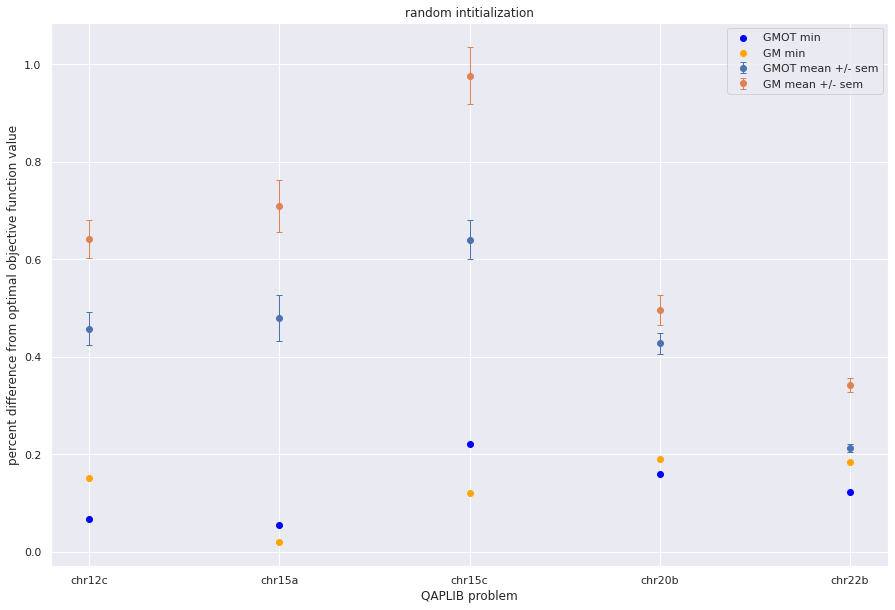

In [176]:
from scipy.stats import sem
import seaborn as sns
opt = mat[:,0].reshape(-1,1)
gmot_pdiff = (gmot_rand - opt)/opt
gm_pdiff = (gm_rand - opt)/opt
gmot_pdiffb = (gmot_bary - opt)/opt
gm_pdiffb = (gm_bary - opt)/opt

sns.set_context('paper')
sns.set(rc={'figure.figsize':(15,10)})
plt.errorbar(qapprob,np.mean(gmot_pdiff,axis=1), sem(gmot_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GMOT mean +/- sem',)
plt.errorbar(qapprob,np.mean(gm_pdiff,axis=1), sem(gm_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM mean +/- sem',)
plt.scatter(qapprob,np.min(gmot_pdiff,axis=1), color='blue', label = "GMOT min")
plt.scatter(qapprob,np.min(gm_pdiff,axis=1), color='orange', label='GM min')
plt.xlabel("QAPLIB problem")
plt.ylabel("percent difference from optimal objective function value")

plt.title('random intitialization')
plt.legend()

Text(0, 0.5, 'percent difference from optimal objective function value')

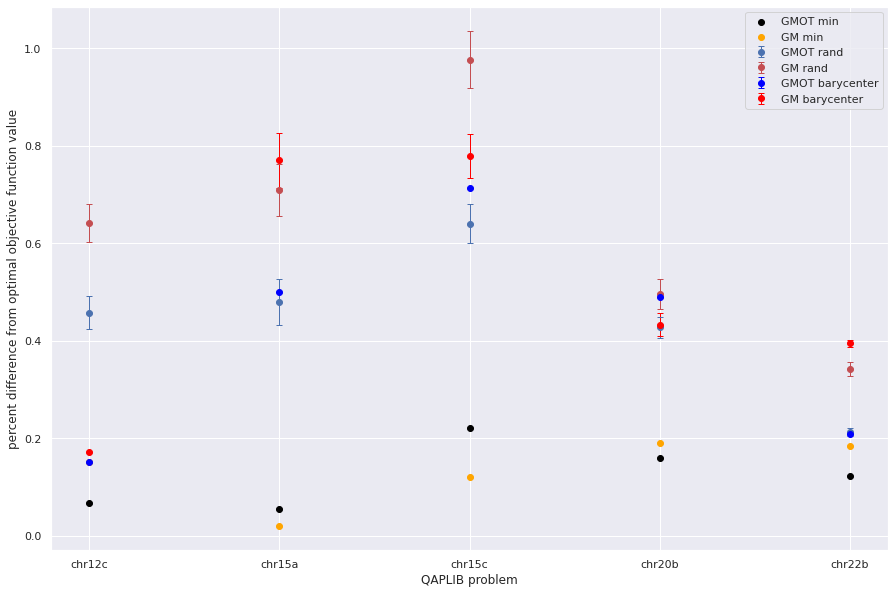

In [177]:
opt = mat[:,0].reshape(-1,1)
gmot_pdiff = (gmot_rand - opt)/opt
gm_pdiff = (gm_rand - opt)/opt
gmot_pdiffb = (gmot_bary - opt)/opt
gm_pdiffb = (gm_bary - opt)/opt

sns.set_context('paper')
sns.set(rc={'figure.figsize':(15,10)})
plt.errorbar(qapprob,np.mean(gmot_pdiff,axis=1), sem(gmot_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GMOT rand',)
plt.errorbar(qapprob,np.mean(gm_pdiff,axis=1), sem(gm_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM rand',color='r')
plt.errorbar(qapprob,np.mean(gmot_pdiffb,axis=1), sem(gmot_pdiffb,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GMOT barycenter',color='blue')
plt.errorbar(qapprob,np.mean(gm_pdiffb,axis=1), sem(gm_pdiffb,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM barycenter',color='red')
plt.scatter(qapprob,np.min(gmot_pdiff,axis=1), color='black', label = "GMOT min")
plt.scatter(qapprob,np.min(gm_pdiff,axis=1), color='orange', label='GM min')

plt.legend()
plt.xlabel("QAPLIB problem")
plt.ylabel("percent difference from optimal objective function value")

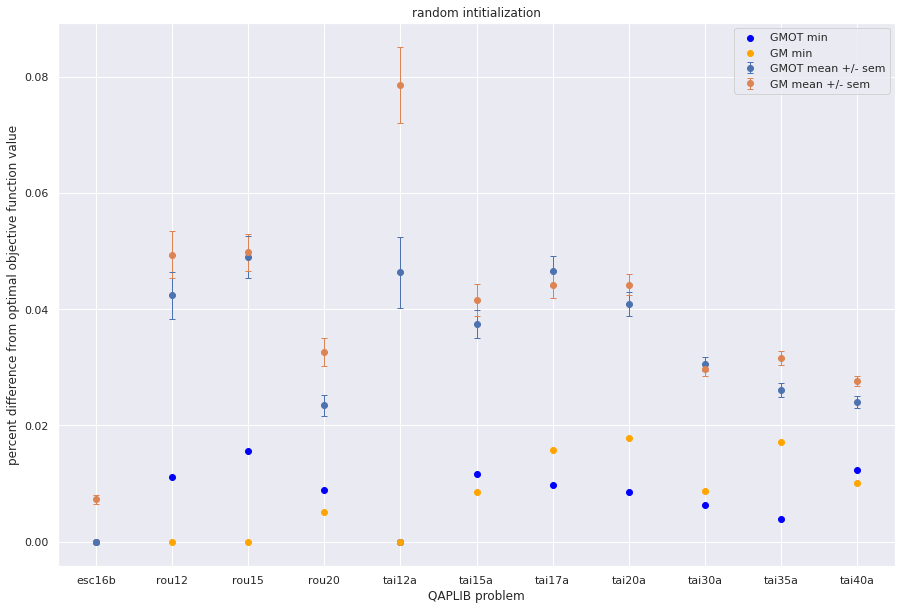

In [182]:
from scipy.stats import sem
import seaborn as sns
opt = mat[:,0].reshape(-1,1)
gmot_pdiff = (gmot_rand - opt)/opt
gm_pdiff = (gm_rand - opt)/opt
gmot_pdiffb = (gmot_bary - opt)/opt
gm_pdiffb = (gm_bary - opt)/opt

sns.set_context('paper')
sns.set(rc={'figure.figsize':(15,10)})
plt.errorbar(qapprob,np.mean(gmot_pdiff,axis=1), sem(gmot_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GMOT mean +/- sem',)
plt.errorbar(qapprob,np.mean(gm_pdiff,axis=1), sem(gm_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM mean +/- sem',)
plt.scatter(qapprob,np.min(gmot_pdiff,axis=1), color='blue', label = "GMOT min")
plt.scatter(qapprob,np.min(gm_pdiff,axis=1), color='orange', label='GM min')
plt.xlabel("QAPLIB problem")
plt.ylabel("percent difference from optimal objective function value")

plt.title('random intitialization')
plt.legend()

Text(0, 0.5, 'percent difference from optimal objective function value')

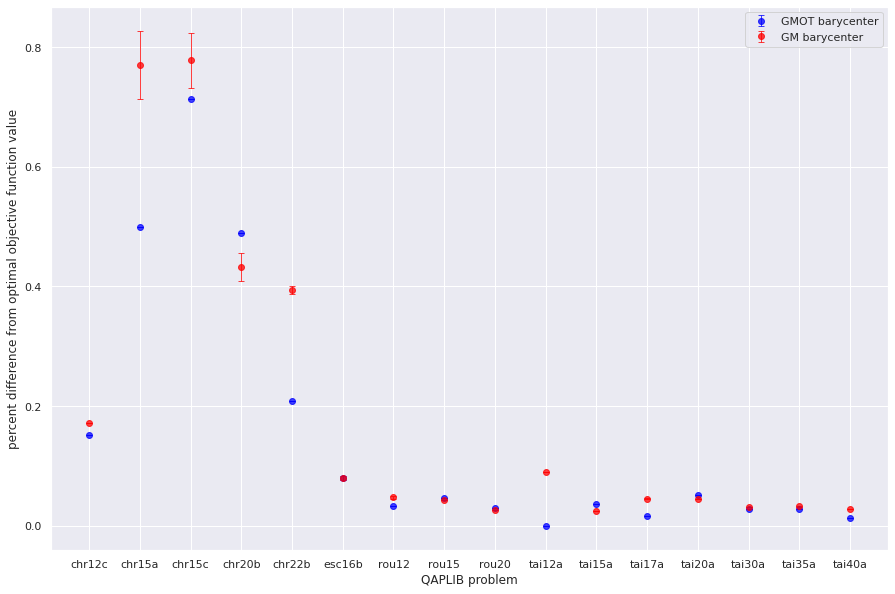

In [275]:
opt = mat[:,0].reshape(-1,1)
gmot_pdiff = (gmot_rand - opt)/opt
gm_pdiff = (gm_rand - opt)/opt
gmot_pdiffb = (gmot_bary - opt)/opt
gm_pdiffb = (gm_bary - opt)/opt

sns.set_context('paper')
sns.set(rc={'figure.figsize':(15,10)})
# plt.errorbar(qapprob,np.mean(gmot_pdiff,axis=1), sem(gmot_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GMOT rand',alpha=0.75,)
# plt.errorbar(qapprob,np.mean(gm_pdiff,axis=1), sem(gm_pdiff,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM rand',alpha=0.75,color='r')
plt.errorbar(qapprob,np.mean(gmot_pdiffb,axis=1), sem(gmot_pdiffb,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GMOT barycenter',alpha=0.75,color='blue')
plt.errorbar(qapprob,np.mean(gm_pdiffb,axis=1), sem(gm_pdiffb,axis=1),fmt='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM barycenter',alpha=0.75,color='red')
# plt.scatter(qapprob,np.min(gmot_pdiff,axis=1), color='black', alpha=0.75,label = "GMOT min")
# plt.scatter(qapprob,np.min(gm_pdiff,axis=1), color='orange', alpha=0.75,label='GM min')

plt.legend()
plt.xlabel("QAPLIB problem")
plt.ylabel("percent difference from optimal objective function value")

In [83]:
def _doubly_stochastic(P, tol=1e-3, max_iter=1000):
    # Adapted from @btaba implementation
    # https://github.com/btaba/sinkhorn_knopp
    # of Sinkhorn-Knopp algorithm
    # https://projecteuclid.org/euclid.pjm/1102992505

    c = 1 / P.sum(axis=0)
    r = 1 / (P @ c)
    P_eps = P

    for it in range(max_iter):
        if it % 100 == 0:  # only check every so often to speed up
            if (np.abs(P_eps.sum(axis=1) - 1) < tol).all() and (
                np.abs(P_eps.sum(axis=0) - 1) < tol
            ).all():
                # All column/row sums ~= 1 within threshold
                break

        c = 1 / (r @ P)
        r = 1 / (P @ c)
        P_eps = r[:, None] * P * c
    return P_eps